In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv')

In [3]:
df

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1
...,...,...,...,...,...,...,...,...,...
1457,referral,manufacturing,1,NaN,self_employed,north_america,4,0.53,1
1458,referral,technology,3,65259.0,student,europe,2,0.24,1
1459,paid_ads,technology,1,45688.0,student,north_america,3,0.02,1
1460,referral,NaN,5,71016.0,self_employed,north_america,0,0.25,1


In [4]:
df.columns

Index(['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income',
       'employment_status', 'location', 'interaction_count', 'lead_score',
       'converted'],
      dtype='object')

In [5]:
category =['lead_source', 'industry','employment_status', 'location']
numerical = [ 'number_of_courses_viewed', 'annual_income','interaction_count', 'lead_score',
       'converted']

In [6]:
# Fill numerical columns with 0
df[df.select_dtypes(include ='number').columns]=df.select_dtypes(include ='number').fillna(0)

# Fill categorical columns with 'NA'
df[df.select_dtypes(exclude='number').columns] = df.select_dtypes(exclude='number').fillna('NA')

In [7]:
#Split the dataset 
train_df, val_df = train_test_split(df, test_size=0.2, random_state=1)
y_train = train_df['converted'].values
y_val = val_df['converted'].values
X_train = train_df.drop(columns=['converted'])
X_val = val_df.drop(columns=['converted'])

## Question 1

In [8]:
from sklearn.metrics import roc_auc_score
num_cols = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']

def auc_for_series(s, y):
    s = pd.Series(s)
    s_filled = s.fillna(s.median())
    if s_filled.nunique(dropna=False) <= 1:
        return 0.5
    return roc_auc_score(y, s_filled)
results=[]
for col in num_cols :
    raw_auc = auc_for_series(train_df[col], y_train)
    if raw_auc < 0.5:
        adj_auc = 1 - raw_auc
        direction = '-'  
    else:
        adj_auc = raw_auc
        direction = '+'  

    results.append({
        'feature': col,
        'raw_auc': round(float(raw_auc), 6),
        'use_direction': direction,
        'auc_after_direction': round(float(adj_auc), 6),
    })

auc_df = pd.DataFrame(results).sort_values('auc_after_direction', ascending=False).reset_index(drop=True)

In [9]:
print(auc_df)
print("\nBest feature by AUC (after direction fix):", auc_df.loc[0, 'feature'])
print("Direction to use:", auc_df.loc[0, 'use_direction'])
print("AUC:", auc_df.loc[0, 'auc_after_direction'])

                    feature   raw_auc use_direction  auc_after_direction
0  number_of_courses_viewed  0.757854             +             0.757854
1         interaction_count  0.727679             +             0.727679
2                lead_score  0.616361             +             0.616361
3             annual_income  0.553333             +             0.553333

Best feature by AUC (after direction fix): number_of_courses_viewed
Direction to use: +
AUC: 0.757854


In [10]:
dv = DictVectorizer(sparse=False)

train_dict = train_df[category + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = val_df[category + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

## Question 2

In [11]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000,random_state = 1)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,1
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [12]:
acc = model.score(X_val, y_val)
print("Validation Accuracy:", round(acc, 3))

Validation Accuracy: 0.809


In [13]:
val_dict = val_df[category + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.8088737201365188)

In [14]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.19, 0.16],
       [0.03, 0.61]])

In [15]:
p = tp / (tp + fp)
r = tp / (tp + fn)
print(p)
print(r)

0.7964601769911505
0.9473684210526315


In [16]:
tpr = tp / (tp + fn)
tpr

np.float64(0.9473684210526315)

In [17]:
fpr = fp / (fp + tn)
fpr

np.float64(0.44660194174757284)

In [18]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

## Question 3 & 4

In [19]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

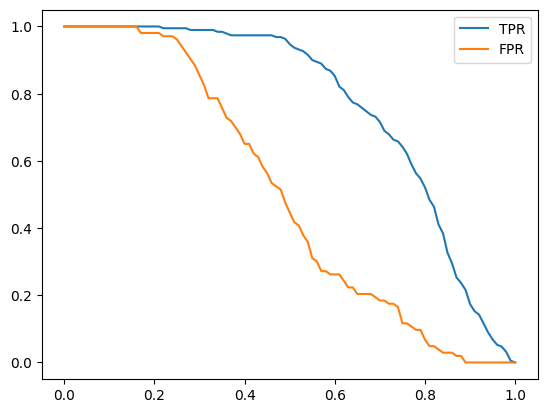

In [20]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

In [21]:
prec_den = (df_scores.tp + df_scores.fp).to_numpy()
rec_den  = (df_scores.tp + df_scores.fn).to_numpy()

df_scores['precision'] = np.where(prec_den > 0, df_scores.tp / prec_den, 0.0)
df_scores['recall']    = np.where(rec_den  > 0, df_scores.tp / rec_den, 0.0)  

# F1 score
pr_sum = (df_scores['precision'] + df_scores['recall']).to_numpy()
df_scores['f1'] = np.where(pr_sum > 0,
                           2 * df_scores['precision'] * df_scores['recall'] / pr_sum,
                           0.0)

# Best threshold by F1
best_idx = df_scores['f1'].idxmax()
best_threshold = float(df_scores.loc[best_idx, 'threshold'])
best_f1 = float(df_scores.loc[best_idx, 'f1'])

print(f"Best threshold: {best_threshold:.2f}")
print(f"Max F1:        {best_f1:.4f}")

Best threshold: 0.57
Max F1:        0.8734


In [22]:
def train(train_df, y_train, C=1.0):
    dicts = train_df[category + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, solver='liblinear',max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [23]:
dv, model = train(train_df, y_train, C=0.001)
def predict(df, dv, model):
    dicts = df[category + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred
y_pred = predict(val_df, dv, model)
from sklearn.model_selection import KFold

## Question 5

In [24]:
!pip install tqdm

In [25]:
from tqdm.auto import tqdm
df = train_df.copy()

n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
splits = list(kfold.split(df))

results = []

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    scores = []

    for train_idx, val_idx in splits:
        df_tr  = df.iloc[train_idx].copy()
        df_val = df.iloc[val_idx].copy()

        y_train = df_tr['converted'].values
        y_val   = df_val['converted'].values

        dv, model = train(df_tr, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    mean_auc = np.mean(scores)
    std_auc = np.std(scores)
    results.append((C, mean_auc, std_auc))
    print(f"C={C:<6} mean AUC={mean_auc:.3f} ± {std_auc:.3f}")

# ---- After all C values ----
best_C, best_mean, best_std = max(results, key=lambda x: x[1])

print("\nBest C value:")
print(f"→ C={best_C} gives highest mean AUC={best_mean:.3f} ± {best_std:.3f}")

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001  mean AUC=0.926 ± 0.018
C=0.01   mean AUC=0.896 ± 0.026
C=0.1    mean AUC=0.878 ± 0.031
C=0.5    mean AUC=0.876 ± 0.032
C=1      mean AUC=0.876 ± 0.032
C=5      mean AUC=0.875 ± 0.032
C=10     mean AUC=0.875 ± 0.032

Best C value:
→ C=0.001 gives highest mean AUC=0.926 ± 0.018


## Question 6

In [26]:
df = train_df.copy()

n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
splits = list(kfold.split(df))

results = []

# Only these C values
for C in tqdm([1e-6, 0.001, 1]):
    scores = []

    for train_idx, val_idx in splits:
        df_tr  = df.iloc[train_idx].copy()
        df_val = df.iloc[val_idx].copy()

        y_train = df_tr['converted'].values
        y_val   = df_val['converted'].values

        dv, model = train(df_tr, y_train, C=C)

        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    mean_auc = float(np.mean(scores))
    std_auc  = float(np.std(scores))
    results.append((C, mean_auc, std_auc))

    print(f"C={C:<8} mean AUC={mean_auc:.3f} ± {std_auc:.3f}")

best_C, best_mean, best_std = max(results, key=lambda x: x[1])
print("\nBest C value:")
print(f"→ C={best_C} gives highest mean AUC={best_mean:.3f} ± {best_std:.3f}")

  0%|          | 0/3 [00:00<?, ?it/s]

C=1e-06    mean AUC=0.561 ± 0.024
C=0.001    mean AUC=0.926 ± 0.018
C=1        mean AUC=0.876 ± 0.032

Best C value:
→ C=0.001 gives highest mean AUC=0.926 ± 0.018
